In [1]:
drop_fbref_for_goalkeepers = True

In [2]:
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import shap
import plotly.graph_objects as go

pd.set_option('display.max_columns', 501)
pd.set_option('display.max_rows', 501)

/Users/jaakkotoivonen/opt/anaconda3/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
def train_model(xgb_params, fit_params, training_X, training_y, testing_X, testing_y):

    # fit model
    model = XGBRegressor(**xgb_params)
    model.fit(training_X, training_y, eval_set=[(testing_X, testing_y)], **fit_params)

    # metrics
    predictions_test = model.predict(testing_X)
    rmse_test = mean_squared_error(testing_y, predictions_test, squared=False)
    mae_test = mean_absolute_error(testing_y, predictions_test)
    r2_test = r2_score(testing_y, predictions_test)
    print(f'Test RMSE: {rmse_test}')
    print(f'Test MAE: {mae_test}')
    print(f'Test R2: {r2_test}')
    
    return model

In [5]:
data = []
for j in range(1,11):
    data.append(pd.read_csv(f'../../data/data_for_modelling_game_{j}.csv', index_col=0))
    # for goalkeepers, drop a bunch of fbref stat categories that generally are not applicable for goalkeepers
    if drop_fbref_for_goalkeepers:
        # columns_for_ewa2 also used later
        columns_for_ewa2 = ['Performance_Sh', 'Performance_SoT', 'Performance_Touches', 'Performance_Press', 'Performance_Tkl',
                      'Performance_Int', 'Performance_Blocks', 'Expected_xG', 'Expected_npxG', 'Expected_xA',
                      'SCA_SCA', 'Passes_Cmp', 'Passes_Cmp%', 'Passes_Prog', 'Carries_Carries', 'Carries_Prog',
                      'Dribbles_Succ', 'Dribbles_Att', 'General_KP', 'Touches_Att 3rd', 'Touches_Att Pen', 
                       'Performance_Recov', 'Aerial Duels_Won', 'Aerial Duels_Won%']
        ewa_intervals = [5,10,20,40]
        for i in ewa_intervals:
            new_ewa_columns2 = [col+f'_ewa_{i}_shifted_{j}' for col in columns_for_ewa2]
        data[j-1].loc[data[j-1]['fpl_position_GK']==1, new_ewa_columns2] = np.nan

In [6]:
training_full = []
testing_full = []
for j in range(1,11):
    training_full.append(
                    data[j-1][(data[j-1]['season']=='2017-18') | (data[j-1]['season']=='2018-19') | 
                         (data[j-1]['season']=='2019-20') | (data[j-1]['season']=='2020-21')].copy()
                        )
    testing_full.append(data[j-1][(data[j-1]['season']=='2021-22')].copy())

In [21]:
training = []
testing = []
training_X = []
training_y = []
testing_X = []
testing_y = []

for j in range(1,11):

    # declare all variables that will go into the model
    target = 'total_points'
    input_variables = ['was_home', 'fpl_position_GK', 'fpl_position_DEF', 'fpl_position_MID', 'fpl_position_FWD',
            f'team_xG_ewa_5_shifted_{j}', f'team_xG_ewa_10_shifted_{j}',
           f'team_xG_ewa_20_shifted_{j}', f'team_xG_ewa_40_shifted_{j}',
           f'team_xGA_ewa_5_shifted_{j}', f'team_xGA_ewa_10_shifted_{j}',
           f'team_xGA_ewa_20_shifted_{j}', f'team_xGA_ewa_40_shifted_{j}', f'opp_team_xG_ewa_5_shifted_{j}',
           f'opp_team_xG_ewa_10_shifted_{j}', f'opp_team_xG_ewa_20_shifted_{j}',
           f'opp_team_xG_ewa_40_shifted_{j}', f'opp_team_xGA_ewa_5_shifted_{j}',
           f'opp_team_xGA_ewa_10_shifted_{j}', f'opp_team_xGA_ewa_20_shifted_{j}',
           f'opp_team_xGA_ewa_40_shifted_{j}', f'games_in_past_5_days_shifted_{j-1}',
           f'games_in_past_10_days_shifted_{j-1}', f'games_in_past_20_days_shifted_{j-1}', 
           f'games_in_past_40_days_shifted_{j-1}',
            f'transfers_balance_%_shifted_{j}', f'transfers_balance_%_ewa5_shifted_{j}', 
           f'transfers_balance_%_ewa10_shifted_{j}',
            f'value_change_1_shifted_{j}', f'value_change_2_shifted_{j}', f'value_change_5_shifted_{j}', 
           f'goal_to_xg_ratio_ewa_40_shifted{j}']

    columns_for_ewa1 = ['total_points', 'xPoints', 'assists', 'bonus', 'bps', 'clean_sheets', 'creativity', 
                       'goals_conceded', 'goals_scored', 'ict_index', 'influence', 'minutes', 'own_goals', 'penalties_missed',
                       'penalties_saved', 'saves', 'threat', 'yellow_cards',]

    columns_for_ewa2 = ['Performance_Sh', 'Performance_SoT', 'Performance_Touches', 'Performance_Press', 'Performance_Tkl',
                      'Performance_Int', 'Performance_Blocks', 'Expected_xG', 'Expected_npxG', 'Expected_xA',
                      'SCA_SCA', 'Passes_Cmp', 'Passes_Cmp%', 'Passes_Prog', 'Carries_Carries', 'Carries_Prog',
                      'Dribbles_Succ', 'Dribbles_Att', 'General_KP', 'Touches_Att 3rd', 'Touches_Att Pen', 
                       'Performance_Recov', 'Aerial Duels_Won', 'Aerial Duels_Won%']

    fbref_position_columns_ordered = ['fbref_position_GK', 'fbref_position_LB', 'fbref_position_CB', 'fbref_position_RB', 
                    'fbref_position_WB', 'fbref_position_DM', 'fbref_position_LM', 'fbref_position_CM', 
                    'fbref_position_RM', 'fbref_position_AM', 'fbref_position_LW', 'fbref_position_RW',
                    'fbref_position_FW', 
                    ]

    ewa_intervals = [5,10,20,40]
    
    for i in ewa_intervals:
        new_ewa_columns1 = [col+f'_ewa_{i}_shifted_{j}' for col in columns_for_ewa1]
        new_ewa_columns2 = [col+f'_ewa_{i}_shifted_{j}' for col in columns_for_ewa2]
        new_fbref_columns = [col+f'_ewa{i}_shifted_{j}' for col in fbref_position_columns_ordered]
        input_variables.extend(new_ewa_columns1)
        input_variables.extend(new_ewa_columns2)
        input_variables.extend(new_fbref_columns)

    keep = [target] + input_variables

    training.append(training_full[j-1][keep].copy())
    testing.append(testing_full[j-1][keep].copy())
    training_X.append(training[j-1][input_variables].copy())
    training_y.append(training[j-1][target].copy())
    testing_X.append(testing[j-1][input_variables].copy())
    testing_y.append(testing[j-1][target].copy())

In [24]:
j=5
print('training_X:')
display(training_X[j-1])
print('training_y:')
display(training_y[j-1])
print('testing_X:')
display(testing_X[j-1])
print('testing_y:')
display(testing_y[j-1])

training_X:


,was_home,fpl_position_GK,fpl_position_DEF,fpl_position_MID,fpl_position_FWD,team_xG_ewa_5_shifted_5,team_xG_ewa_10_shifted_5,team_xG_ewa_20_shifted_5,team_xG_ewa_40_shifted_5,team_xGA_ewa_5_shifted_5,team_xGA_ewa_10_shifted_5,team_xGA_ewa_20_shifted_5,team_xGA_ewa_40_shifted_5,opp_team_xG_ewa_5_shifted_5,opp_team_xG_ewa_10_shifted_5,opp_team_xG_ewa_20_shifted_5,opp_team_xG_ewa_40_shifted_5,opp_team_xGA_ewa_5_shifted_5,opp_team_xGA_ewa_10_shifted_5,opp_team_xGA_ewa_20_shifted_5,opp_team_xGA_ewa_40_shifted_5,games_in_past_5_days_shifted_4,games_in_past_10_days_shifted_4,games_in_past_20_days_shifted_4,games_in_past_40_days_shifted_4,transfers_balance_%_shifted_5,transfers_balance_%_ewa5_shifted_5,transfers_balance_%_ewa10_shifted_5,value_change_1_shifted_5,value_change_2_shifted_5,value_change_5_shifted_5,goal_to_xg_ratio_ewa_40_shifted5,total_points_ewa_5_shifted_5,xPoints_ewa_5_shifted_5,assists_ewa_5_shifted_5,bonus_ewa_5_shifted_5,bps_ewa_5_shifted_5,clean_sheets_ewa_5_shifted_5,creativity_ewa_5_shifted_5,goals_conceded_ewa_5_shifted_5,goals_scored_ewa_5_shifted_5,ict_index_ewa_5_shifted_5,influence_ewa_5_shifted_5,minutes_ewa_5_shifted_5,own_goals_ewa_5_shifted_5,penalties_missed_ewa_5_shifted_5,penalties_saved_ewa_5_shifted_5,saves_ewa_5_shifted_5,threat_ewa_5_shifted_5,yellow_cards_ewa_5_shifted_5,Performance_Sh_ewa_5_shifted_5,Performance_SoT_ewa_5_shifted_5,Performance_Touches_ewa_5_shifted_5,Performance_Press_ewa_5_shifted_5,Performance_Tkl_ewa_5_shifted_5,Performance_Int_ewa_5_shifted_5,Performance_Blocks_ewa_5_shifted_5,Expected_xG_ewa_5_shifted_5,Expected_npxG_ewa_5_shifted_5,Expected_xA_ewa_5_shifted_5,SCA_SCA_ewa_5_shifted_5,Passes_Cmp_ewa_5_shifted_5,Passes_Cmp%_ewa_5_shifted_5,Passes_Prog_ewa_5_shifted_5,Carries_Carries_ewa_5_shifted_5,Carries_Prog_ewa_5_shifted_5,Dribbles_Succ_ewa_5_shifted_5,Dribbles_Att_ewa_5_shifted_5,General_KP_ewa_5_shifted_5,Touches_Att 3rd_ewa_5_shifted_5,Touches_Att Pen_ewa_5_shifted_5,Performance_Recov_ewa_5_shifted_5,Aerial Duels_Won_ewa_5_shifted_5,Aerial Duels_Won%_ewa_5_shifted_5,fbref_position_GK_ewa5_shifted_5,fbref_position_LB_ewa5_shifted_5,fbref_position_CB_ewa5_shifted_5,fbref_position_RB_ewa5_shifted_5,fbref_position_WB_ewa5_shifted_5,fbref_position_DM_ewa5_shifted_5,fbref_position_LM_ewa5_shifted_5,fbref_position_CM_ewa5_shifted_5,fbref_position_RM_ewa5_shifted_5,fbref_position_AM_ewa5_shifted_5,fbref_position_LW_ewa5_shifted_5,fbref_position_RW_ewa5_shifted_5,fbref_position_FW_ewa5_shifted_5,total_points_ewa_10_shifted_5,xPoints_ewa_10_shifted_5,assists_ewa_10_shifted_5,bonus_ewa_10_shifted_5,bps_ewa_10_shifted_5,clean_sheets_ewa_10_shifted_5,creativity_ewa_10_shifted_5,goals_conceded_ewa_10_shifted_5,goals_scored_ewa_10_shifted_5,ict_index_ewa_10_shifted_5,influence_ewa_10_shifted_5,minutes_ewa_10_shifted_5,own_goals_ewa_10_shifted_5,penalties_missed_ewa_10_shifted_5,penalties_saved_ewa_10_shifted_5,saves_ewa_10_shifted_5,threat_ewa_10_shifted_5,yellow_cards_ewa_10_shifted_5,Performance_Sh_ewa_10_shifted_5,Performance_SoT_ewa_10_shifted_5,Performance_Touches_ewa_10_shifted_5,Performance_Press_ewa_10_shifted_5,Performance_Tkl_ewa_10_shifted_5,Performance_Int_ewa_10_shifted_5,Performance_Blocks_ewa_10_shifted_5,Expected_xG_ewa_10_shifted_5,Expected_npxG_ewa_10_shifted_5,Expected_xA_ewa_10_shifted_5,SCA_SCA_ewa_10_shifted_5,Passes_Cmp_ewa_10_shifted_5,Passes_Cmp%_ewa_10_shifted_5,Passes_Prog_ewa_10_shifted_5,Carries_Carries_ewa_10_shifted_5,Carries_Prog_ewa_10_shifted_5,Dribbles_Succ_ewa_10_shifted_5,Dribbles_Att_ewa_10_shifted_5,General_KP_ewa_10_shifted_5,Touches_Att 3rd_ewa_10_shifted_5,Touches_Att Pen_ewa_10_shifted_5,Performance_Recov_ewa_10_shifted_5,Aerial Duels_Won_ewa_10_shifted_5,Aerial Duels_Won%_ewa_10_shifted_5,fbref_position_GK_ewa10_shifted_5,fbref_position_LB_ewa10_shifted_5,fbref_position_CB_ewa10_shifted_5,fbref_position_RB_ewa10_shifted_5,fbref_position_WB_ewa10_shifted_5,fbref_position_DM_ewa10_shifted_5,fbref_position_LM_ewa10_shifted_5,fbref_position_C

training_y:


0        0
1752     1
3513     1
5141     6
5295     9
        ..
31594    7
31456    1
31714    1
31510    1
31530    1
Name: total_points, Length: 31619, dtype: int64

testing_X:


,was_home,fpl_position_GK,fpl_position_DEF,fpl_position_MID,fpl_position_FWD,team_xG_ewa_5_shifted_5,team_xG_ewa_10_shifted_5,team_xG_ewa_20_shifted_5,team_xG_ewa_40_shifted_5,team_xGA_ewa_5_shifted_5,team_xGA_ewa_10_shifted_5,team_xGA_ewa_20_shifted_5,team_xGA_ewa_40_shifted_5,opp_team_xG_ewa_5_shifted_5,opp_team_xG_ewa_10_shifted_5,opp_team_xG_ewa_20_shifted_5,opp_team_xG_ewa_40_shifted_5,opp_team_xGA_ewa_5_shifted_5,opp_team_xGA_ewa_10_shifted_5,opp_team_xGA_ewa_20_shifted_5,opp_team_xGA_ewa_40_shifted_5,games_in_past_5_days_shifted_4,games_in_past_10_days_shifted_4,games_in_past_20_days_shifted_4,games_in_past_40_days_shifted_4,transfers_balance_%_shifted_5,transfers_balance_%_ewa5_shifted_5,transfers_balance_%_ewa10_shifted_5,value_change_1_shifted_5,value_change_2_shifted_5,value_change_5_shifted_5,goal_to_xg_ratio_ewa_40_shifted5,total_points_ewa_5_shifted_5,xPoints_ewa_5_shifted_5,assists_ewa_5_shifted_5,bonus_ewa_5_shifted_5,bps_ewa_5_shifted_5,clean_sheets_ewa_5_shifted_5,creativity_ewa_5_shifted_5,goals_conceded_ewa_5_shifted_5,goals_scored_ewa_5_shifted_5,ict_index_ewa_5_shifted_5,influence_ewa_5_shifted_5,minutes_ewa_5_shifted_5,own_goals_ewa_5_shifted_5,penalties_missed_ewa_5_shifted_5,penalties_saved_ewa_5_shifted_5,saves_ewa_5_shifted_5,threat_ewa_5_shifted_5,yellow_cards_ewa_5_shifted_5,Performance_Sh_ewa_5_shifted_5,Performance_SoT_ewa_5_shifted_5,Performance_Touches_ewa_5_shifted_5,Performance_Press_ewa_5_shifted_5,Performance_Tkl_ewa_5_shifted_5,Performance_Int_ewa_5_shifted_5,Performance_Blocks_ewa_5_shifted_5,Expected_xG_ewa_5_shifted_5,Expected_npxG_ewa_5_shifted_5,Expected_xA_ewa_5_shifted_5,SCA_SCA_ewa_5_shifted_5,Passes_Cmp_ewa_5_shifted_5,Passes_Cmp%_ewa_5_shifted_5,Passes_Prog_ewa_5_shifted_5,Carries_Carries_ewa_5_shifted_5,Carries_Prog_ewa_5_shifted_5,Dribbles_Succ_ewa_5_shifted_5,Dribbles_Att_ewa_5_shifted_5,General_KP_ewa_5_shifted_5,Touches_Att 3rd_ewa_5_shifted_5,Touches_Att Pen_ewa_5_shifted_5,Performance_Recov_ewa_5_shifted_5,Aerial Duels_Won_ewa_5_shifted_5,Aerial Duels_Won%_ewa_5_shifted_5,fbref_position_GK_ewa5_shifted_5,fbref_position_LB_ewa5_shifted_5,fbref_position_CB_ewa5_shifted_5,fbref_position_RB_ewa5_shifted_5,fbref_position_WB_ewa5_shifted_5,fbref_position_DM_ewa5_shifted_5,fbref_position_LM_ewa5_shifted_5,fbref_position_CM_ewa5_shifted_5,fbref_position_RM_ewa5_shifted_5,fbref_position_AM_ewa5_shifted_5,fbref_position_LW_ewa5_shifted_5,fbref_position_RW_ewa5_shifted_5,fbref_position_FW_ewa5_shifted_5,total_points_ewa_10_shifted_5,xPoints_ewa_10_shifted_5,assists_ewa_10_shifted_5,bonus_ewa_10_shifted_5,bps_ewa_10_shifted_5,clean_sheets_ewa_10_shifted_5,creativity_ewa_10_shifted_5,goals_conceded_ewa_10_shifted_5,goals_scored_ewa_10_shifted_5,ict_index_ewa_10_shifted_5,influence_ewa_10_shifted_5,minutes_ewa_10_shifted_5,own_goals_ewa_10_shifted_5,penalties_missed_ewa_10_shifted_5,penalties_saved_ewa_10_shifted_5,saves_ewa_10_shifted_5,threat_ewa_10_shifted_5,yellow_cards_ewa_10_shifted_5,Performance_Sh_ewa_10_shifted_5,Performance_SoT_ewa_10_shifted_5,Performance_Touches_ewa_10_shifted_5,Performance_Press_ewa_10_shifted_5,Performance_Tkl_ewa_10_shifted_5,Performance_Int_ewa_10_shifted_5,Performance_Blocks_ewa_10_shifted_5,Expected_xG_ewa_10_shifted_5,Expected_npxG_ewa_10_shifted_5,Expected_xA_ewa_10_shifted_5,SCA_SCA_ewa_10_shifted_5,Passes_Cmp_ewa_10_shifted_5,Passes_Cmp%_ewa_10_shifted_5,Passes_Prog_ewa_10_shifted_5,Carries_Carries_ewa_10_shifted_5,Carries_Prog_ewa_10_shifted_5,Dribbles_Succ_ewa_10_shifted_5,Dribbles_Att_ewa_10_shifted_5,General_KP_ewa_10_shifted_5,Touches_Att 3rd_ewa_10_shifted_5,Touches_Att Pen_ewa_10_shifted_5,Performance_Recov_ewa_10_shifted_5,Aerial Duels_Won_ewa_10_shifted_5,Aerial Duels_Won%_ewa_10_shifted_5,fbref_position_GK_ewa10_shifted_5,fbref_position_LB_ewa10_shifted_5,fbref_position_CB_ewa10_shifted_5,fbref_position_RB_ewa10_shifted_5,fbref_position_WB_ewa10_shifted_5,fbref_position_DM_ewa10_shifted_5,fbref_position_LM_ewa10_shifted_5,fbref_position_C

testing_y:


31978    7
32236    2
32489    5
32747    8
33003    1
        ..
40554    1
40555    2
40921    0
40851    1
40970    1
Name: total_points, Length: 9392, dtype: int64

In [4]:
# get the models trained with three years of data
xgb_models = []
for j in range(1,11):
    xgb = XGBRegressor()
    xgb.load_model(f'../../models/xgb_regression_game{j}.json')
    xgb_models.append(xgb)

In [26]:
# re-train models with correct params using also the validation set for training
new_models = []
for j in range(1,11):
    xgb_params = xgb_models[j-1].get_params()
    
    fit_params = {}
    fit_params['early_stopping_rounds'] = 25
    sample_weight = training_X[j-1][f'total_points_ewa_40_shifted_{j}'].fillna(1)
    sample_weight[sample_weight<1] = 1
    fit_params['sample_weight'] = sample_weight
    sample_weight_eval_set = testing_X[j-1][f'total_points_ewa_40_shifted_{j}'].fillna(1)
    sample_weight_eval_set[sample_weight_eval_set<1] = 1
    fit_params['sample_weight_eval_set'] = [sample_weight_eval_set]
    
    new_model = train_model(xgb_params, fit_params, training_X[j-1], training_y[j-1], testing_X[j-1], testing_y[j-1])
    new_models.append(new_model)

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[0]	validation_0-rmse:4.21236
[1]	validation_0-rmse:4.09843
[2]	validation_0-rmse:3.99398
[3]	validation_0-rmse:3.90014
[4]	validation_0-rmse:3.81606
[5]	validation_0-rmse:3.74087
[6]	validation_0-rmse:3.67382
[7]	validation_0-rmse:3.61379
[8]	validation_0-rmse:3.56032
[9]	validation_0-rmse:3.51259
[10]	validation_0-rmse:3.46895
[11]	validation_0-rmse:3.43052
[12]	validation_0-rmse:3.39630
[13]	validation_0-rmse:3.36466
[14]	validation_0-rmse:3.33872
[15]	validation_0-rmse:3.31441
[16]	validation_0-rmse:3.29266
[17]	validation_0-rmse:3.27374
[18]	validation_0-rmse:3.25693
[19]	validation_0-rmse:3.24110
[20]	validation_0-rmse:3.22808
[21]	validation_0-rmse:3.21636
[22]	validation_0-rmse:3.20617
[23]	validation_0-rmse:3.19694
[24]	validation_0-rmse:3.18773
[25]	validation_0-rmse:3.18069
[26]	validation_0-rmse:3.17334
[27]	validation_0-rmse:3.16838
[28]	validation_0-rmse:3.16252
[29]	validation_0-rmse:3.15774
[30]	validation_0-rmse:3.15328
[31]	validation_0-rmse:3.14924
[32]	validation_0-

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[0]	validation_0-rmse:4.19302
[1]	validation_0-rmse:4.06307
[2]	validation_0-rmse:3.94903
[3]	validation_0-rmse:3.85059
[4]	validation_0-rmse:3.75980
[5]	validation_0-rmse:3.68162
[6]	validation_0-rmse:3.61247
[7]	validation_0-rmse:3.54981
[8]	validation_0-rmse:3.49588
[9]	validation_0-rmse:3.44986
[10]	validation_0-rmse:3.40777
[11]	validation_0-rmse:3.37194
[12]	validation_0-rmse:3.34117
[13]	validation_0-rmse:3.31336
[14]	validation_0-rmse:3.28829
[15]	validation_0-rmse:3.26791
[16]	validation_0-rmse:3.24893
[17]	validation_0-rmse:3.23362
[18]	validation_0-rmse:3.22153
[19]	validation_0-rmse:3.20886
[20]	validation_0-rmse:3.19861
[21]	validation_0-rmse:3.19003
[22]	validation_0-rmse:3.18193
[23]	validation_0-rmse:3.17516
[24]	validation_0-rmse:3.16778
[25]	validation_0-rmse:3.16348
[26]	validation_0-rmse:3.15891
[27]	validation_0-rmse:3.15457
[28]	validation_0-rmse:3.15138
[29]	validation_0-rmse:3.14778
[30]	validation_0-rmse:3.14500
[31]	validation_0-rmse:3.14193
[32]	validation_0-

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[0]	validation_0-rmse:4.12867
[1]	validation_0-rmse:3.94751
[2]	validation_0-rmse:3.79688
[3]	validation_0-rmse:3.67658
[4]	validation_0-rmse:3.57528
[5]	validation_0-rmse:3.49075
[6]	validation_0-rmse:3.42259
[7]	validation_0-rmse:3.36668
[8]	validation_0-rmse:3.32340
[9]	validation_0-rmse:3.28952
[10]	validation_0-rmse:3.26134
[11]	validation_0-rmse:3.23782
[12]	validation_0-rmse:3.21757
[13]	validation_0-rmse:3.20143
[14]	validation_0-rmse:3.19015
[15]	validation_0-rmse:3.18090
[16]	validation_0-rmse:3.17405
[17]	validation_0-rmse:3.16795
[18]	validation_0-rmse:3.16241
[19]	validation_0-rmse:3.16102
[20]	validation_0-rmse:3.15614
[21]	validation_0-rmse:3.15402
[22]	validation_0-rmse:3.15353
[23]	validation_0-rmse:3.15333
[24]	validation_0-rmse:3.15036
[25]	validation_0-rmse:3.14921
[26]	validation_0-rmse:3.14733
[27]	validation_0-rmse:3.14747
[28]	validation_0-rmse:3.14877
[29]	validation_0-rmse:3.14688
[30]	validation_0-rmse:3.14619
[31]	validation_0-rmse:3.14718
[32]	validation_0-

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[0]	validation_0-rmse:4.25026
[1]	validation_0-rmse:4.16184
[2]	validation_0-rmse:4.07780
[3]	validation_0-rmse:4.00004
[4]	validation_0-rmse:3.92854
[5]	validation_0-rmse:3.86166
[6]	validation_0-rmse:3.80072
[7]	validation_0-rmse:3.74387
[8]	validation_0-rmse:3.69083
[9]	validation_0-rmse:3.64515
[10]	validation_0-rmse:3.60171
[11]	validation_0-rmse:3.56228
[12]	validation_0-rmse:3.52557
[13]	validation_0-rmse:3.49234
[14]	validation_0-rmse:3.46027
[15]	validation_0-rmse:3.43305
[16]	validation_0-rmse:3.40658
[17]	validation_0-rmse:3.38281
[18]	validation_0-rmse:3.36143
[19]	validation_0-rmse:3.34119
[20]	validation_0-rmse:3.32284
[21]	validation_0-rmse:3.30686
[22]	validation_0-rmse:3.29172
[23]	validation_0-rmse:3.27803
[24]	validation_0-rmse:3.26484
[25]	validation_0-rmse:3.25373
[26]	validation_0-rmse:3.24244
[27]	validation_0-rmse:3.23292
[28]	validation_0-rmse:3.22372
[29]	validation_0-rmse:3.21718
[30]	validation_0-rmse:3.21042
[31]	validation_0-rmse:3.20454
[32]	validation_0-

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[0]	validation_0-rmse:4.26599
[1]	validation_0-rmse:4.19826
[2]	validation_0-rmse:4.13347
[3]	validation_0-rmse:4.07155
[4]	validation_0-rmse:4.01359
[5]	validation_0-rmse:3.95948
[6]	validation_0-rmse:3.90782
[7]	validation_0-rmse:3.85956
[8]	validation_0-rmse:3.81398
[9]	validation_0-rmse:3.77002
[10]	validation_0-rmse:3.72935
[11]	validation_0-rmse:3.69213
[12]	validation_0-rmse:3.65799
[13]	validation_0-rmse:3.62437
[14]	validation_0-rmse:3.59274
[15]	validation_0-rmse:3.56311
[16]	validation_0-rmse:3.53474
[17]	validation_0-rmse:3.50906
[18]	validation_0-rmse:3.48356
[19]	validation_0-rmse:3.46006
[20]	validation_0-rmse:3.43978
[21]	validation_0-rmse:3.42003
[22]	validation_0-rmse:3.40060
[23]	validation_0-rmse:3.38250
[24]	validation_0-rmse:3.36597
[25]	validation_0-rmse:3.35100
[26]	validation_0-rmse:3.33633
[27]	validation_0-rmse:3.32237
[28]	validation_0-rmse:3.31133
[29]	validation_0-rmse:3.30032
[30]	validation_0-rmse:3.28962
[31]	validation_0-rmse:3.27837
[32]	validation_0-

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[0]	validation_0-rmse:3.90770
[1]	validation_0-rmse:3.62905
[2]	validation_0-rmse:3.45163
[3]	validation_0-rmse:3.33755
[4]	validation_0-rmse:3.26450
[5]	validation_0-rmse:3.21966
[6]	validation_0-rmse:3.19151
[7]	validation_0-rmse:3.17340
[8]	validation_0-rmse:3.16343
[9]	validation_0-rmse:3.15411
[10]	validation_0-rmse:3.14629
[11]	validation_0-rmse:3.14338
[12]	validation_0-rmse:3.14184
[13]	validation_0-rmse:3.14147
[14]	validation_0-rmse:3.14159
[15]	validation_0-rmse:3.14032
[16]	validation_0-rmse:3.13868
[17]	validation_0-rmse:3.13682
[18]	validation_0-rmse:3.13698
[19]	validation_0-rmse:3.13971
[20]	validation_0-rmse:3.14022
[21]	validation_0-rmse:3.13888
[22]	validation_0-rmse:3.13952
[23]	validation_0-rmse:3.14440
[24]	validation_0-rmse:3.14297
[25]	validation_0-rmse:3.14252
[26]	validation_0-rmse:3.14115
[27]	validation_0-rmse:3.14093
[28]	validation_0-rmse:3.14019
[29]	validation_0-rmse:3.14053
[30]	validation_0-rmse:3.14192
[31]	validation_0-rmse:3.14298
[32]	validation_0-

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[0]	validation_0-rmse:3.79782
[1]	validation_0-rmse:3.49888
[2]	validation_0-rmse:3.33912
[3]	validation_0-rmse:3.25403
[4]	validation_0-rmse:3.20432
[5]	validation_0-rmse:3.18033
[6]	validation_0-rmse:3.16648
[7]	validation_0-rmse:3.15928
[8]	validation_0-rmse:3.15669
[9]	validation_0-rmse:3.15432
[10]	validation_0-rmse:3.15323
[11]	validation_0-rmse:3.15269
[12]	validation_0-rmse:3.15011
[13]	validation_0-rmse:3.15081
[14]	validation_0-rmse:3.15001
[15]	validation_0-rmse:3.14860
[16]	validation_0-rmse:3.14688
[17]	validation_0-rmse:3.14439
[18]	validation_0-rmse:3.14498
[19]	validation_0-rmse:3.14594
[20]	validation_0-rmse:3.14616
[21]	validation_0-rmse:3.14675
[22]	validation_0-rmse:3.14646
[23]	validation_0-rmse:3.14615
[24]	validation_0-rmse:3.14663
[25]	validation_0-rmse:3.14597
[26]	validation_0-rmse:3.14399
[27]	validation_0-rmse:3.14129
[28]	validation_0-rmse:3.14084
[29]	validation_0-rmse:3.13977
[30]	validation_0-rmse:3.14000
[31]	validation_0-rmse:3.14000
[32]	validation_0-

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[0]	validation_0-rmse:4.16749
[1]	validation_0-rmse:4.01785
[2]	validation_0-rmse:3.88762
[3]	validation_0-rmse:3.77467
[4]	validation_0-rmse:3.68069
[5]	validation_0-rmse:3.59920
[6]	validation_0-rmse:3.53117
[7]	validation_0-rmse:3.47368
[8]	validation_0-rmse:3.42370
[9]	validation_0-rmse:3.38194
[10]	validation_0-rmse:3.34430
[11]	validation_0-rmse:3.31359
[12]	validation_0-rmse:3.28747
[13]	validation_0-rmse:3.26421
[14]	validation_0-rmse:3.24657
[15]	validation_0-rmse:3.23189
[16]	validation_0-rmse:3.22052
[17]	validation_0-rmse:3.21051
[18]	validation_0-rmse:3.20034
[19]	validation_0-rmse:3.19209
[20]	validation_0-rmse:3.18551
[21]	validation_0-rmse:3.17940
[22]	validation_0-rmse:3.17563
[23]	validation_0-rmse:3.17242
[24]	validation_0-rmse:3.16855
[25]	validation_0-rmse:3.16561
[26]	validation_0-rmse:3.16336
[27]	validation_0-rmse:3.16167
[28]	validation_0-rmse:3.15957
[29]	validation_0-rmse:3.15826
[30]	validation_0-rmse:3.15747
[31]	validation_0-rmse:3.15648
[32]	validation_0-

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[0]	validation_0-rmse:4.17180
[1]	validation_0-rmse:4.02540
[2]	validation_0-rmse:3.89980
[3]	validation_0-rmse:3.79177
[4]	validation_0-rmse:3.70088
[5]	validation_0-rmse:3.62048
[6]	validation_0-rmse:3.55083
[7]	validation_0-rmse:3.49066
[8]	validation_0-rmse:3.43768
[9]	validation_0-rmse:3.39601
[10]	validation_0-rmse:3.35821
[11]	validation_0-rmse:3.32864
[12]	validation_0-rmse:3.30172
[13]	validation_0-rmse:3.27813
[14]	validation_0-rmse:3.26036
[15]	validation_0-rmse:3.24557
[16]	validation_0-rmse:3.23242
[17]	validation_0-rmse:3.22011
[18]	validation_0-rmse:3.21038
[19]	validation_0-rmse:3.20283
[20]	validation_0-rmse:3.19604
[21]	validation_0-rmse:3.19013
[22]	validation_0-rmse:3.18470
[23]	validation_0-rmse:3.18056
[24]	validation_0-rmse:3.17621
[25]	validation_0-rmse:3.17226
[26]	validation_0-rmse:3.16872
[27]	validation_0-rmse:3.16589
[28]	validation_0-rmse:3.16559
[29]	validation_0-rmse:3.16436
[30]	validation_0-rmse:3.16178
[31]	validation_0-rmse:3.16131
[32]	validation_0-

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


[1]	validation_0-rmse:4.22656
[2]	validation_0-rmse:4.16847
[3]	validation_0-rmse:4.11201
[4]	validation_0-rmse:4.05942
[5]	validation_0-rmse:4.00897
[6]	validation_0-rmse:3.96096
[7]	validation_0-rmse:3.91630
[8]	validation_0-rmse:3.87353
[9]	validation_0-rmse:3.83411
[10]	validation_0-rmse:3.79601
[11]	validation_0-rmse:3.75929
[12]	validation_0-rmse:3.72476
[13]	validation_0-rmse:3.69225
[14]	validation_0-rmse:3.66222
[15]	validation_0-rmse:3.63297
[16]	validation_0-rmse:3.60513
[17]	validation_0-rmse:3.57959
[18]	validation_0-rmse:3.55441
[19]	validation_0-rmse:3.53131
[20]	validation_0-rmse:3.50952
[21]	validation_0-rmse:3.48820
[22]	validation_0-rmse:3.46785
[23]	validation_0-rmse:3.45003
[24]	validation_0-rmse:3.43327
[25]	validation_0-rmse:3.41686
[26]	validation_0-rmse:3.40079
[27]	validation_0-rmse:3.38593
[28]	validation_0-rmse:3.37220
[29]	validation_0-rmse:3.35993
[30]	validation_0-rmse:3.34834
[31]	validation_0-rmse:3.33704
[32]	validation_0-rmse:3.32679
[33]	validation_0

# Figures

In [37]:
def draw_player_predictions(name_string, testing_full, model, input_variables):
    
    aux = testing_full[testing_full['name'].str.contains(name_string)]
    y_true = aux['total_points']
    xPoints = aux['xPoints']
    y_pred = model.predict(aux[input_variables])

    fig = go.Figure()

    fig.add_trace(
        go.Scatter(
            x=aux['GW'],
            y=y_true,
           mode="markers+lines",
            name='true points'
        )
    )

    fig.add_trace(
        go.Scatter(
            x=aux['GW'],
            y=xPoints,
           mode="markers+lines",
            name='xPoints'
        )
    )

    fig.add_trace(
        go.Scatter(
            x=aux['GW'],
            y=y_pred,
           mode="markers+lines",
            name='predicted points'
        )
    )

    #fig.update_xaxes(range=[predictions.min()-1, predictions.max()+1])

    fig.update_layout(
        title=aux['name'].unique()[0],
        xaxis_title="gameweek",
        yaxis_title="points",
        showlegend=True
        )

    fig.show()

    print(f'Total true points: {np.sum(y_true)}')
    print(f'Total expected points: {np.sum(xPoints)}')
    print(f'Total predicted points: {np.sum(y_pred)}')

In [38]:
def calculate_all_player_predictions(testing_full, model, input_variables):
    
    player_names = testing_full['name'].unique()
    stats = []
    for player_name in player_names:
        aux = testing_full[testing_full['name']==player_name]
        total_points = aux['total_points'].sum()
        xPoints = aux['xPoints'].sum()
        predicted_points = model.predict(aux[input_variables]).sum()
        stats.append((player_name, total_points, xPoints, predicted_points))

    stats_df = pd.DataFrame(data=stats, columns=['name', 'total_points', 'xPoints', 'predicted_points'])
    
    return stats_df

In [29]:
def draw_all_predictions(stats_df):
    
    fig = go.Figure()

    fig.add_trace(
        go.Scatter(
            x=stats_df['predicted_points'],
            y=stats_df['total_points'],
            hovertext=stats_df['name'],
           mode="markers",
            #opacity=0.6,
        )
    )

    fig.add_trace(
        go.Scatter(
            x=np.linspace(0,250,100),
            y=np.linspace(0,250,100),
           mode="lines",
        )
    )

    #fig.update_xaxes(range=[predictions_test.min()-1, predictions_test.max()+1])

    fig.update_layout(
        title="Test set",
        xaxis_title="predicted points",
        yaxis_title="true points",
        showlegend=False
        )

    fig.show()

In [150]:
# which model are we plotting and saving?
j=10

In [151]:
# input variables
# declare all variables that will go into the model
target = 'total_points'
input_variables = ['was_home', 'fpl_position_GK', 'fpl_position_DEF', 'fpl_position_MID', 'fpl_position_FWD',
        f'team_xG_ewa_5_shifted_{j}', f'team_xG_ewa_10_shifted_{j}',
       f'team_xG_ewa_20_shifted_{j}', f'team_xG_ewa_40_shifted_{j}',
       f'team_xGA_ewa_5_shifted_{j}', f'team_xGA_ewa_10_shifted_{j}',
       f'team_xGA_ewa_20_shifted_{j}', f'team_xGA_ewa_40_shifted_{j}', f'opp_team_xG_ewa_5_shifted_{j}',
       f'opp_team_xG_ewa_10_shifted_{j}', f'opp_team_xG_ewa_20_shifted_{j}',
       f'opp_team_xG_ewa_40_shifted_{j}', f'opp_team_xGA_ewa_5_shifted_{j}',
       f'opp_team_xGA_ewa_10_shifted_{j}', f'opp_team_xGA_ewa_20_shifted_{j}',
       f'opp_team_xGA_ewa_40_shifted_{j}', f'games_in_past_5_days_shifted_{j-1}',
       f'games_in_past_10_days_shifted_{j-1}', f'games_in_past_20_days_shifted_{j-1}', 
       f'games_in_past_40_days_shifted_{j-1}',
        f'transfers_balance_%_shifted_{j}', f'transfers_balance_%_ewa5_shifted_{j}', 
       f'transfers_balance_%_ewa10_shifted_{j}',
        f'value_change_1_shifted_{j}', f'value_change_2_shifted_{j}', f'value_change_5_shifted_{j}', 
       f'goal_to_xg_ratio_ewa_40_shifted{j}']

columns_for_ewa1 = ['total_points', 'xPoints', 'assists', 'bonus', 'bps', 'clean_sheets', 'creativity', 
                   'goals_conceded', 'goals_scored', 'ict_index', 'influence', 'minutes', 'own_goals', 'penalties_missed',
                   'penalties_saved', 'saves', 'threat', 'yellow_cards',]

columns_for_ewa2 = ['Performance_Sh', 'Performance_SoT', 'Performance_Touches', 'Performance_Press', 'Performance_Tkl',
                  'Performance_Int', 'Performance_Blocks', 'Expected_xG', 'Expected_npxG', 'Expected_xA',
                  'SCA_SCA', 'Passes_Cmp', 'Passes_Cmp%', 'Passes_Prog', 'Carries_Carries', 'Carries_Prog',
                  'Dribbles_Succ', 'Dribbles_Att', 'General_KP', 'Touches_Att 3rd', 'Touches_Att Pen', 
                   'Performance_Recov', 'Aerial Duels_Won', 'Aerial Duels_Won%']

fbref_position_columns_ordered = ['fbref_position_GK', 'fbref_position_LB', 'fbref_position_CB', 'fbref_position_RB', 
                'fbref_position_WB', 'fbref_position_DM', 'fbref_position_LM', 'fbref_position_CM', 
                'fbref_position_RM', 'fbref_position_AM', 'fbref_position_LW', 'fbref_position_RW',
                'fbref_position_FW', 
                ]

ewa_intervals = [5,10,20,40]

for i in ewa_intervals:
    new_ewa_columns1 = [col+f'_ewa_{i}_shifted_{j}' for col in columns_for_ewa1]
    new_ewa_columns2 = [col+f'_ewa_{i}_shifted_{j}' for col in columns_for_ewa2]
    new_fbref_columns = [col+f'_ewa{i}_shifted_{j}' for col in fbref_position_columns_ordered]
    input_variables.extend(new_ewa_columns1)
    input_variables.extend(new_ewa_columns2)
    input_variables.extend(new_fbref_columns)

In [152]:
draw_player_predictions('Salah', testing_full[j-1], new_models[j-1], input_variables)

/Users/jaakkotoivonen/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



Total true points: 265
Total expected points: 240.72014773630892
Total predicted points: 219.4856719970703


In [153]:
stats_df = calculate_all_player_predictions(testing_full[j-1], new_models[j-1], input_variables)

/Users/jaakkotoivonen/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/Users/jaakkotoivonen/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/Users/jaakkotoivonen/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/Users/jaakkotoivonen/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/Users/jaakkotoivonen/opt/anaconda3/lib/

/Users/jaakkotoivonen/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/Users/jaakkotoivonen/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/Users/jaakkotoivonen/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/Users/jaakkotoivonen/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/Users/jaakkotoivonen/opt/anaconda3/lib/

/Users/jaakkotoivonen/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/Users/jaakkotoivonen/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/Users/jaakkotoivonen/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/Users/jaakkotoivonen/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/Users/jaakkotoivonen/opt/anaconda3/lib/

/Users/jaakkotoivonen/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/Users/jaakkotoivonen/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/Users/jaakkotoivonen/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/Users/jaakkotoivonen/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/Users/jaakkotoivonen/opt/anaconda3/lib/

/Users/jaakkotoivonen/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/Users/jaakkotoivonen/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/Users/jaakkotoivonen/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/Users/jaakkotoivonen/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/Users/jaakkotoivonen/opt/anaconda3/lib/

/Users/jaakkotoivonen/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/Users/jaakkotoivonen/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/Users/jaakkotoivonen/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/Users/jaakkotoivonen/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/Users/jaakkotoivonen/opt/anaconda3/lib/

/Users/jaakkotoivonen/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/Users/jaakkotoivonen/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/Users/jaakkotoivonen/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/Users/jaakkotoivonen/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/Users/jaakkotoivonen/opt/anaconda3/lib/

/Users/jaakkotoivonen/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/Users/jaakkotoivonen/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/Users/jaakkotoivonen/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/Users/jaakkotoivonen/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/Users/jaakkotoivonen/opt/anaconda3/lib/

/Users/jaakkotoivonen/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/Users/jaakkotoivonen/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/Users/jaakkotoivonen/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/Users/jaakkotoivonen/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/Users/jaakkotoivonen/opt/anaconda3/lib/

/Users/jaakkotoivonen/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/Users/jaakkotoivonen/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/Users/jaakkotoivonen/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/Users/jaakkotoivonen/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/Users/jaakkotoivonen/opt/anaconda3/lib/

/Users/jaakkotoivonen/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/Users/jaakkotoivonen/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/Users/jaakkotoivonen/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/Users/jaakkotoivonen/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/Users/jaakkotoivonen/opt/anaconda3/lib/

In [154]:
draw_all_predictions(stats_df)

In [155]:
explainer = shap.Explainer(new_models[j-1])
shap_values = explainer(data[j-1][input_variables])

/Users/jaakkotoivonen/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py:105: UserWarning:

ntree_limit is deprecated, use `iteration_range` or model slicing instead.



ALL PLAYERS


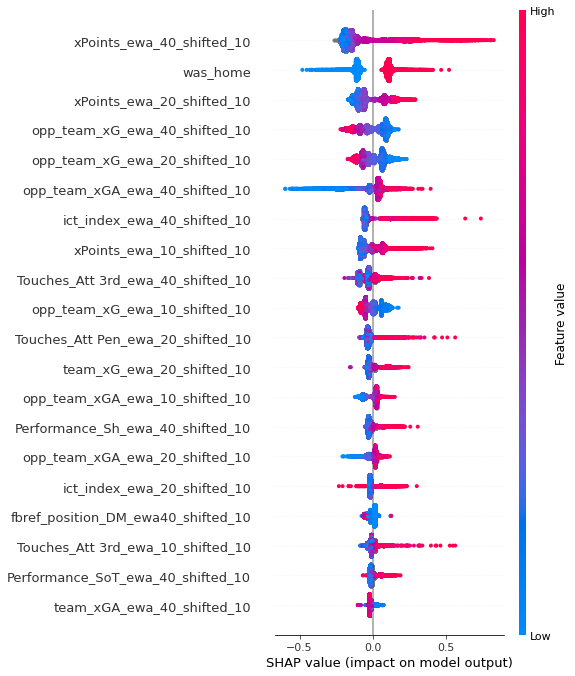

None

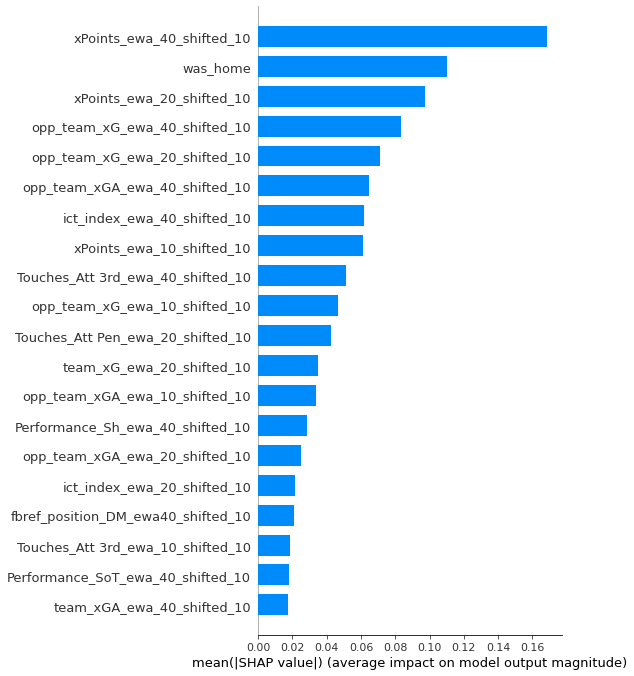

None

In [156]:
print('ALL PLAYERS')
display(shap.summary_plot(shap_values, max_display=20))
display(shap.summary_plot(shap_values, plot_type='bar'))

GOALKEEPERS


/Users/jaakkotoivonen/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1374: RuntimeWarning:

All-NaN slice encountered



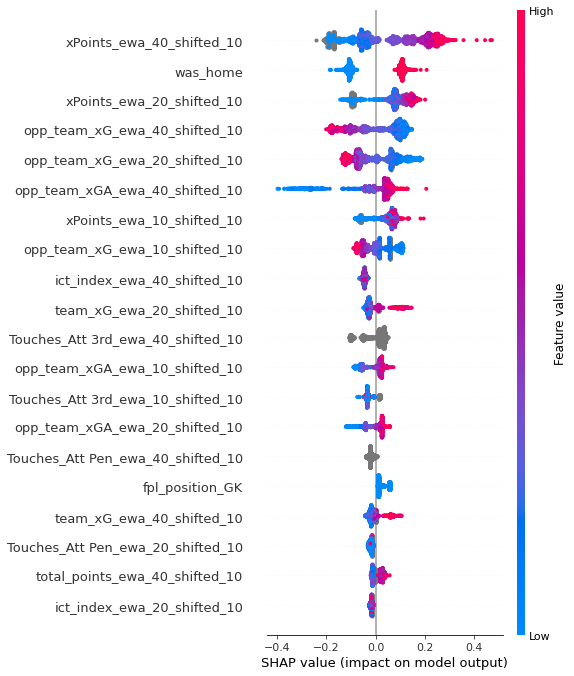

None

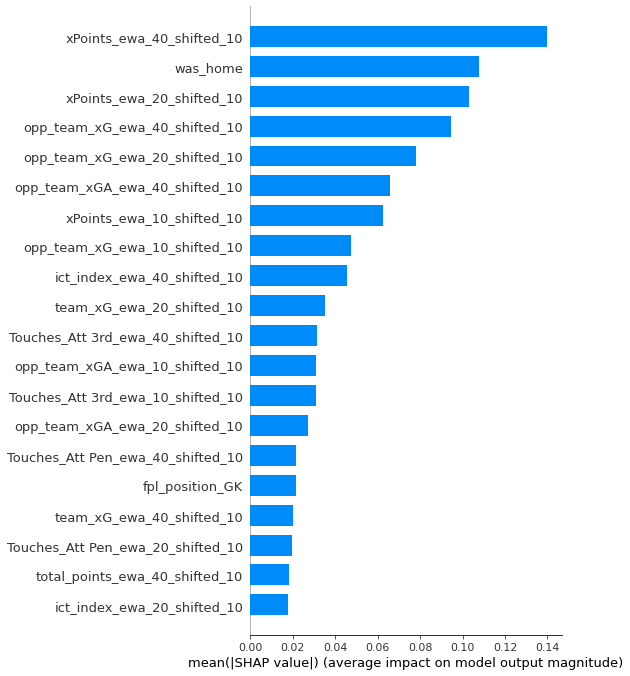

None

In [157]:
print('GOALKEEPERS')
display(shap.summary_plot(shap_values[(data[j-1]['fpl_position_GK']==1).values], max_display=20))
display(shap.summary_plot(shap_values[(data[j-1]['fpl_position_GK']==1).values], max_display=20, plot_type='bar'))

DEFENDERS


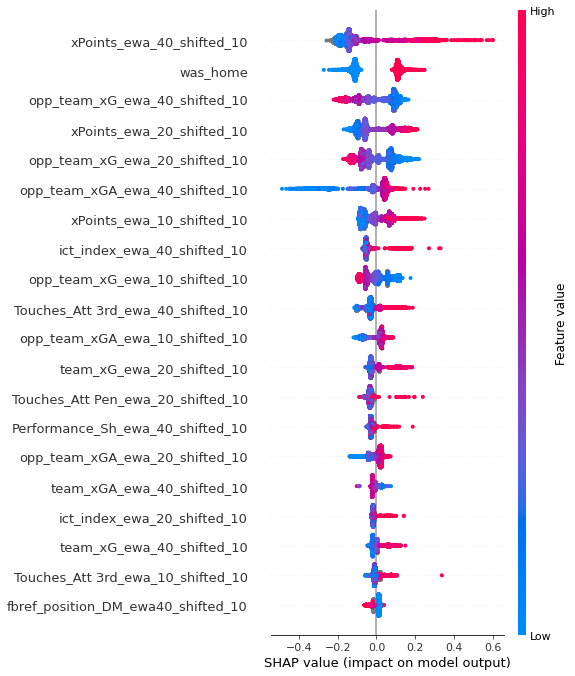

None

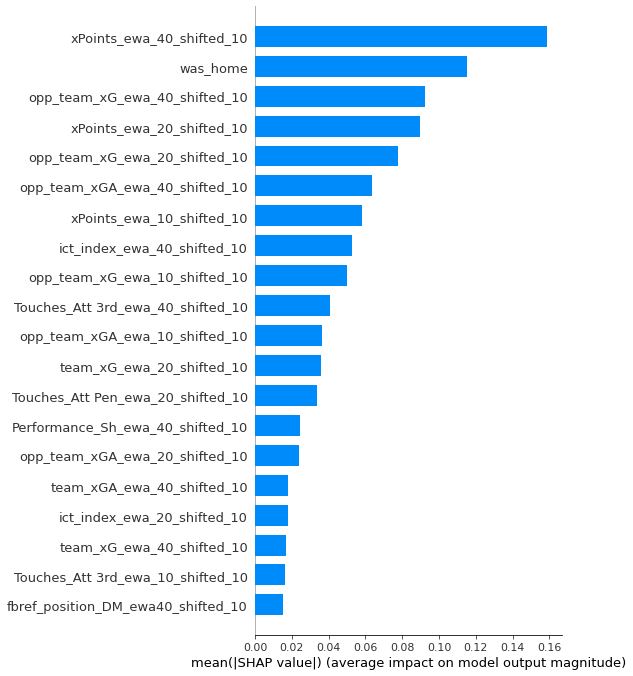

None

In [158]:
print('DEFENDERS')
display(shap.summary_plot(shap_values[(data[j-1]['fpl_position_DEF']==1).values], max_display=20))
display(shap.summary_plot(shap_values[(data[j-1]['fpl_position_DEF']==1).values], max_display=20, plot_type='bar'))

MIDFIELDERS


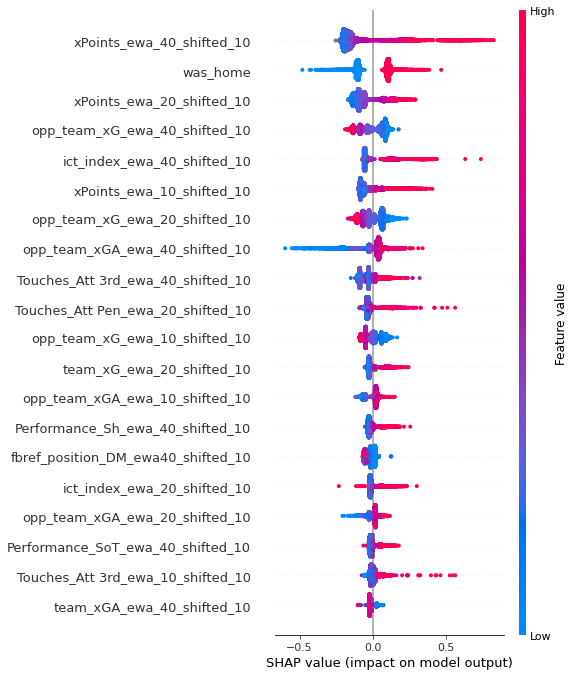

None

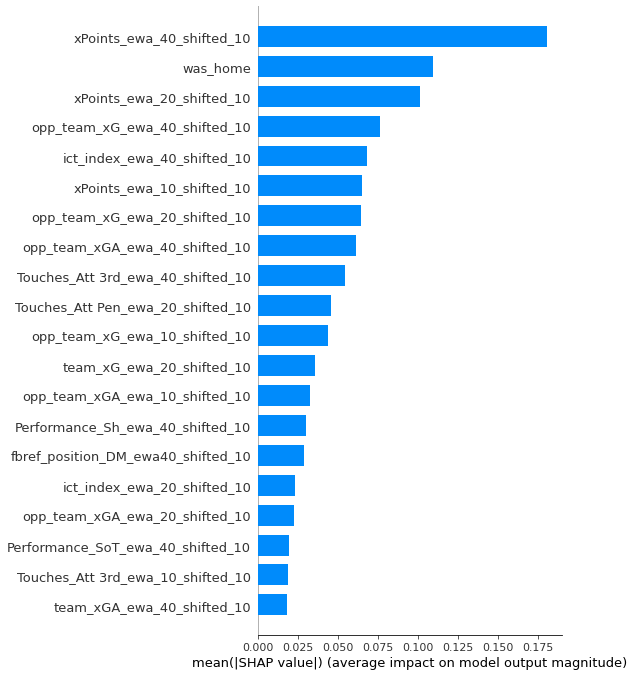

None

In [159]:
print('MIDFIELDERS')
display(shap.summary_plot(shap_values[(data[j-1]['fpl_position_MID']==1).values], max_display=20))
display(shap.summary_plot(shap_values[(data[j-1]['fpl_position_MID']==1).values], max_display=20, plot_type='bar'))

FORWARDS


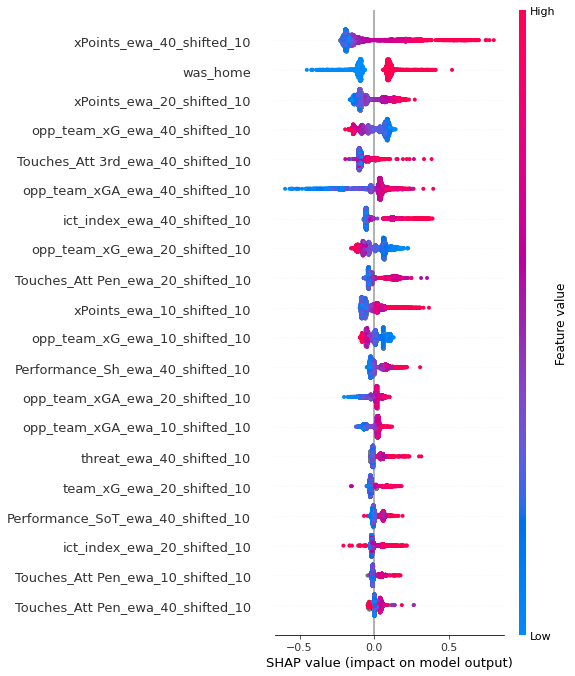

None

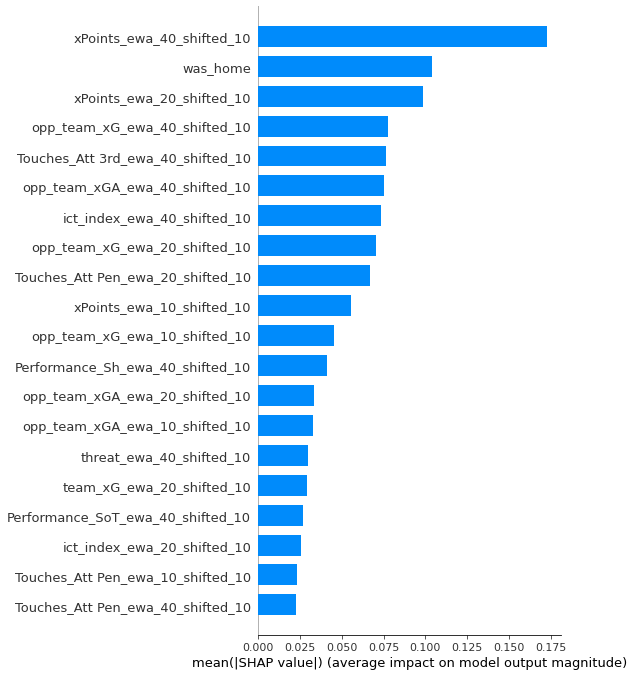

None

In [160]:
print('FORWARDS')
display(shap.summary_plot(shap_values[(data[j-1]['fpl_position_FWD']==1).values], max_display=20))
display(shap.summary_plot(shap_values[(data[j-1]['fpl_position_FWD']==1).values], max_display=20, plot_type='bar'))

In [161]:
# save model
new_models[j-1].save_model(f"../../models/xgb_regression_full_game{j}.json")